# Sound Data Collection and Processing

This notebook processes audio samples, applies augmentations, and extracts features for the User Identity and Product Recommendation System.

## Objectives:
1. Load and display sound samples as waveforms and spectrograms
2. Apply at least two augmentations per sample (pitch shift, time stretch, background noise)
3. Extract features (MFCCs, spectral roll-off, energy)
4. Save features to audio_features.csv


## 0. Install Required Packages

**Run this cell first if you haven't installed the packages yet!**

If you get a `ModuleNotFoundError`, run the cell below to install all required packages.


In [2]:
# Install required packages (run this cell if you get ModuleNotFoundError)
# This will install all necessary packages for audio processing

%pip install numpy pandas librosa matplotlib scipy soundfile

print("\n✓ Installation complete! You can now run the import cell below.")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.

✓ Installation complete! You can now run the import cell below.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\ngami\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 1. Import Required Libraries


In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots (try different style names for compatibility)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        print("Using default matplotlib style")

%matplotlib inline


## 2. Load Audio Samples


In [4]:
# Configuration
AUDIO_DIR = "Audio samples"
SAMPLE_RATE = 22050

# Find all audio files
audio_files = list(Path(AUDIO_DIR).glob("*.m4a"))
audio_files.extend(list(Path(AUDIO_DIR).glob("*.wav")))
audio_files.extend(list(Path(AUDIO_DIR).glob("*.mp3")))

print(f"Found {len(audio_files)} audio file(s):")
for f in audio_files:
    print(f"  - {f.name}")


Found 2 audio file(s):
  - Confirm transaction.wav
  - Yes, approve.wav


## 3. Load and Visualize Original Audio Samples


In [5]:
def load_audio(filepath, sr=SAMPLE_RATE):
    """Load audio file."""
    y, sr = librosa.load(filepath, sr=sr, mono=True)
    return y, sr

# Load all audio samples
audio_data = {}
for audio_file in audio_files:
    label = audio_file.stem
    audio, sr = load_audio(str(audio_file))
    audio_data[label] = {'audio': audio, 'sr': sr, 'filepath': str(audio_file)}
    print(f"Loaded {label}: duration = {len(audio)/sr:.2f}s, sample_rate = {sr}Hz")


Loaded Confirm transaction: duration = 4.67s, sample_rate = 22050Hz
Loaded Yes, approve: duration = 3.56s, sample_rate = 22050Hz


### 3.1 Display Waveforms


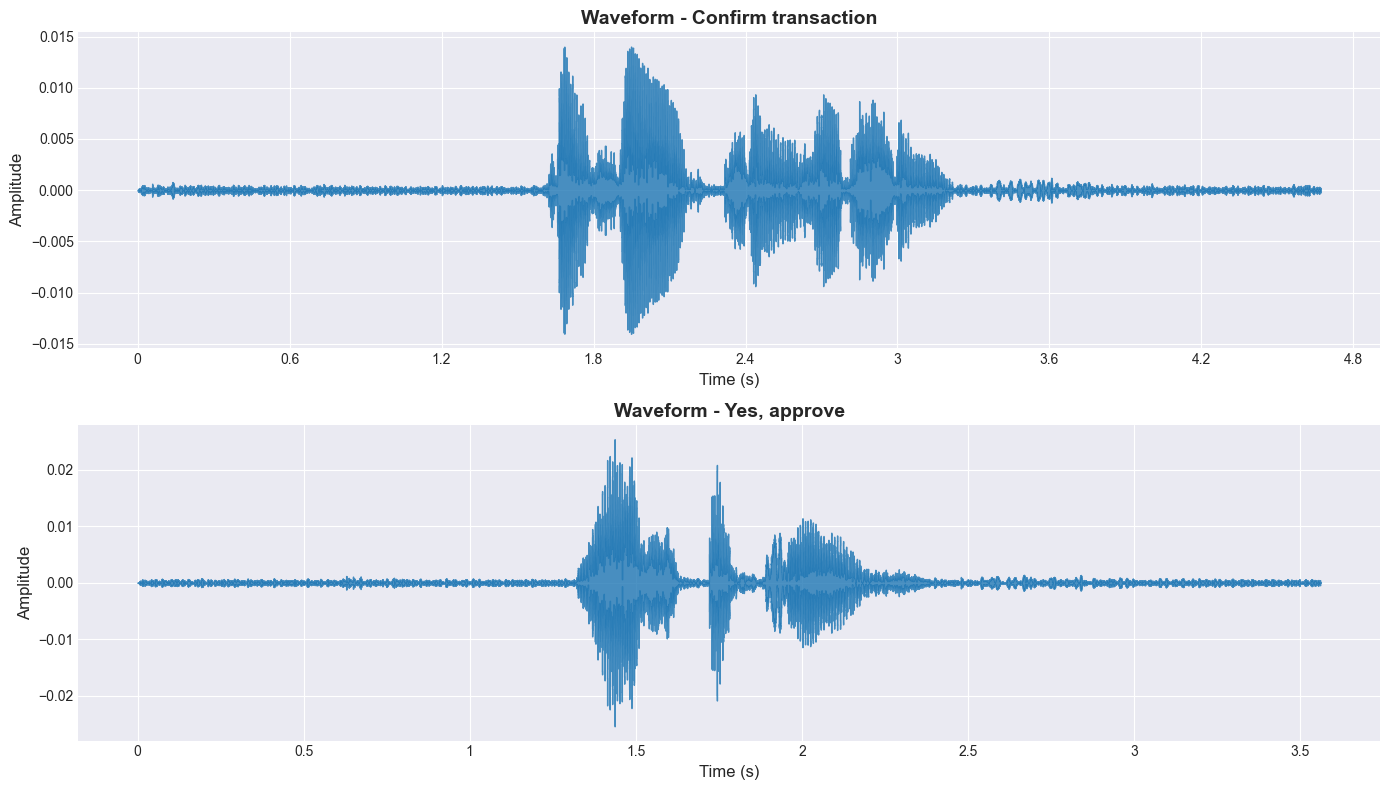

In [6]:
# Plot waveforms for each sample
fig, axes = plt.subplots(len(audio_data), 1, figsize=(14, 4*len(audio_data)))
if len(audio_data) == 1:
    axes = [axes]

for idx, (label, data) in enumerate(audio_data.items()):
    librosa.display.waveshow(data['audio'], sr=data['sr'], ax=axes[idx], alpha=0.8)
    axes[idx].set_title(f"Waveform - {label}", fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Time (s)', fontsize=12)
    axes[idx].set_ylabel('Amplitude', fontsize=12)

plt.tight_layout()
plt.show()


### 3.2 Display Spectrograms


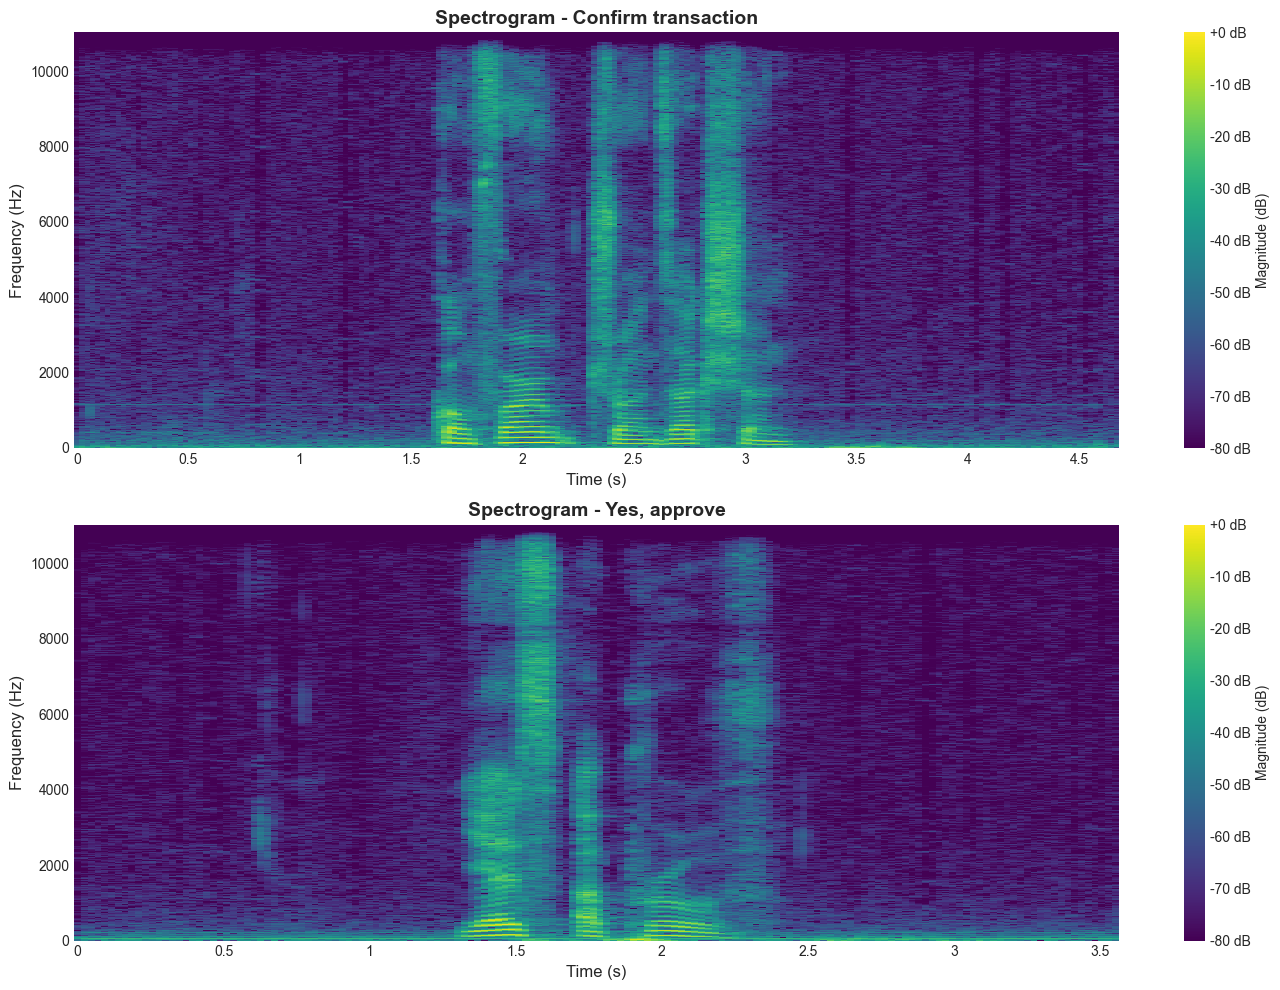

In [7]:
# Plot spectrograms for each sample
fig, axes = plt.subplots(len(audio_data), 1, figsize=(14, 5*len(audio_data)))
if len(audio_data) == 1:
    axes = [axes]

for idx, (label, data) in enumerate(audio_data.items()):
    D = librosa.stft(data['audio'])
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    img = librosa.display.specshow(S_db, sr=data['sr'], x_axis='time', y_axis='hz', 
                                   hop_length=512, cmap='viridis', ax=axes[idx])
    axes[idx].set_title(f"Spectrogram - {label}", fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Time (s)', fontsize=12)
    axes[idx].set_ylabel('Frequency (Hz)', fontsize=12)
    plt.colorbar(img, ax=axes[idx], format='%+2.0f dB', label='Magnitude (dB)')

plt.tight_layout()
plt.show()


## 4. Apply Audio Augmentations

We will apply at least 2 augmentations per sample:
1. **Pitch Shift**: Changes the pitch without changing the speed
2. **Time Stretch**: Changes the speed without changing the pitch
3. **Add Noise**: Adds background noise to simulate real-world conditions


In [8]:
def augment_pitch_shift(audio, sr, n_steps=2):
    """Apply pitch shift augmentation."""
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def augment_time_stretch(audio, rate=1.2):
    """Apply time stretch augmentation."""
    return librosa.effects.time_stretch(audio, rate=rate)

def augment_add_noise(audio, noise_factor=0.005):
    """Add background noise to audio."""
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise


In [9]:
# Apply augmentations to each sample
augmented_data = {}

for label, data in audio_data.items():
    audio = data['audio']
    sr = data['sr']
    
    augmented_data[label] = {
        'original': audio,
        'pitch_shift': augment_pitch_shift(audio, sr, n_steps=2),
        'time_stretch': augment_time_stretch(audio, rate=1.2),
        'add_noise': augment_add_noise(audio, noise_factor=0.005)
    }
    
    print(f"Applied augmentations to: {label}")
    print(f"  - Original duration: {len(audio)/sr:.2f}s")
    print(f"  - Pitch shift duration: {len(augmented_data[label]['pitch_shift'])/sr:.2f}s")
    print(f"  - Time stretch duration: {len(augmented_data[label]['time_stretch'])/sr:.2f}s")
    print(f"  - Add noise duration: {len(augmented_data[label]['add_noise'])/sr:.2f}s")
    print()


Applied augmentations to: Confirm transaction
  - Original duration: 4.67s
  - Pitch shift duration: 4.67s
  - Time stretch duration: 3.89s
  - Add noise duration: 4.67s

Applied augmentations to: Yes, approve
  - Original duration: 3.56s
  - Pitch shift duration: 3.56s
  - Time stretch duration: 2.97s
  - Add noise duration: 3.56s



### 4.1 Visualize Augmented Samples (Example: First Sample)


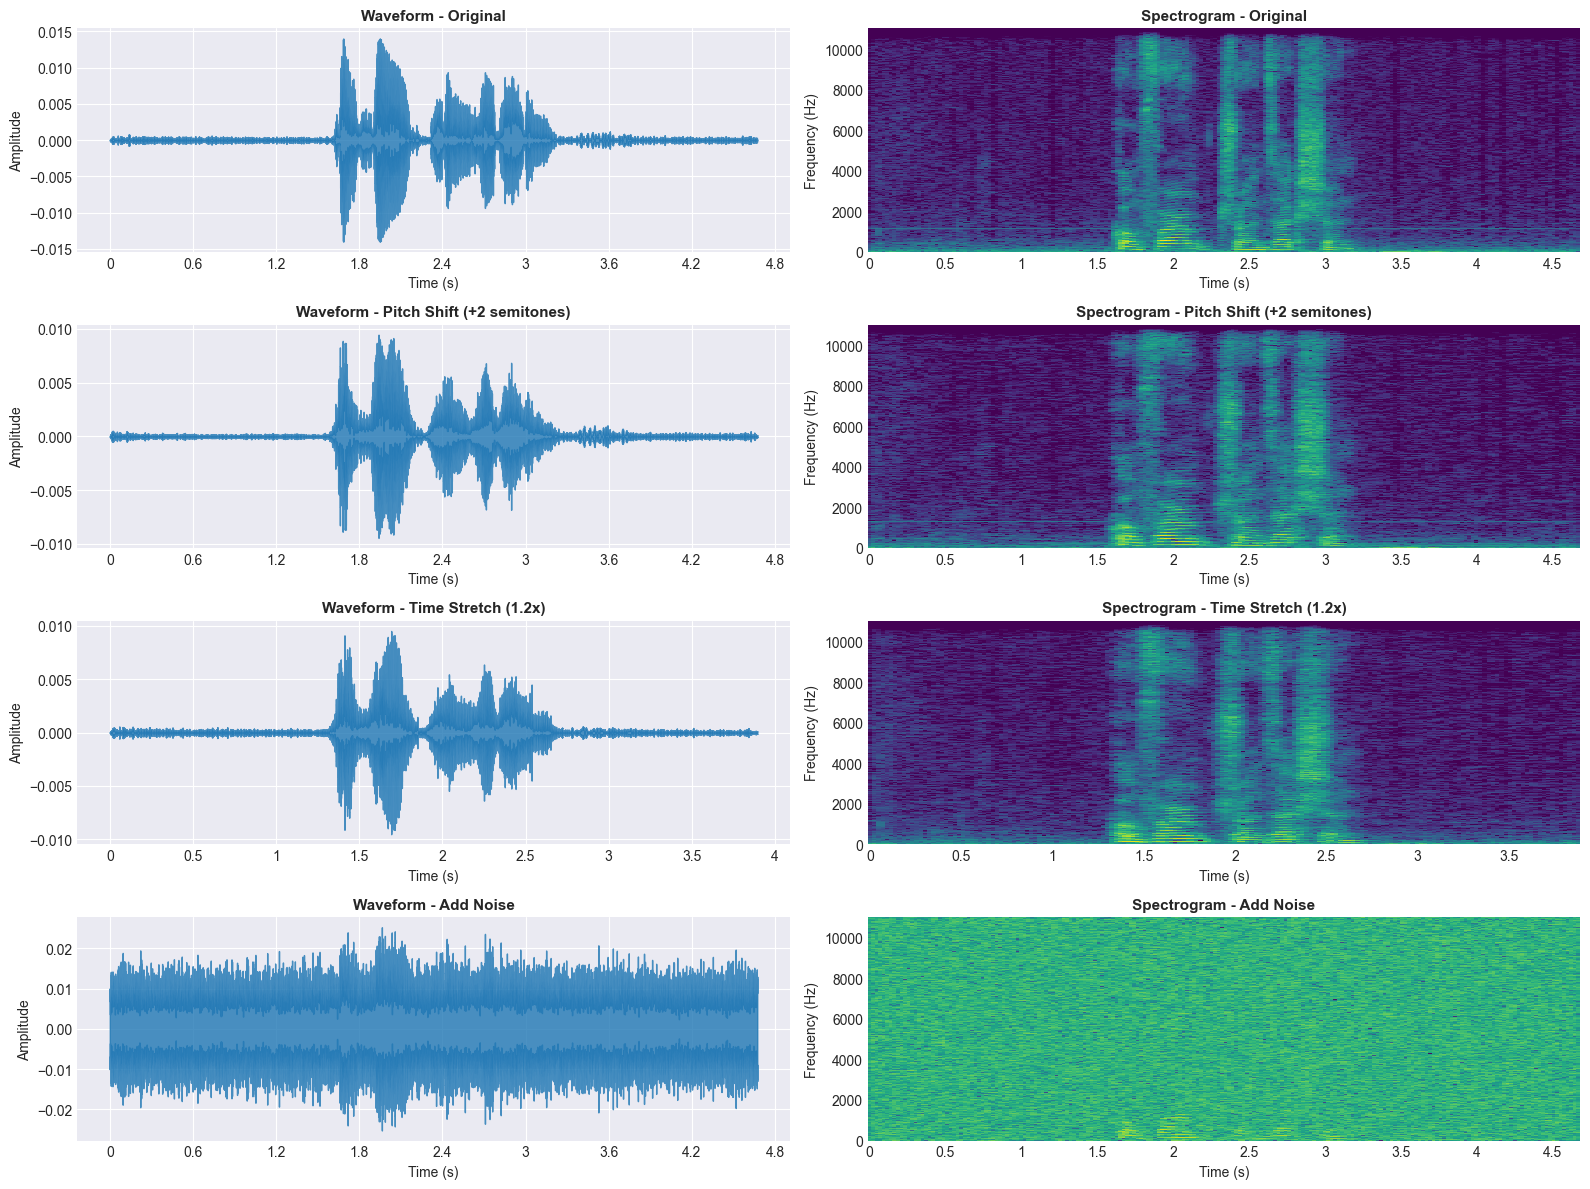

In [10]:
# Visualize augmentations for the first sample
first_label = list(augmented_data.keys())[0]
sample_data = augmented_data[first_label]
sr = audio_data[first_label]['sr']

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
augmentations = ['original', 'pitch_shift', 'time_stretch', 'add_noise']
titles = ['Original', 'Pitch Shift (+2 semitones)', 'Time Stretch (1.2x)', 'Add Noise']

for idx, (aug_type, title) in enumerate(zip(augmentations, titles)):
    audio = sample_data[aug_type]
    
    # Waveform
    librosa.display.waveshow(audio, sr=sr, ax=axes[idx, 0], alpha=0.8)
    axes[idx, 0].set_title(f"Waveform - {title}", fontsize=11, fontweight='bold')
    axes[idx, 0].set_xlabel('Time (s)')
    axes[idx, 0].set_ylabel('Amplitude')
    
    # Spectrogram
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', 
                                   hop_length=512, cmap='viridis', ax=axes[idx, 1])
    axes[idx, 1].set_title(f"Spectrogram - {title}", fontsize=11, fontweight='bold')
    axes[idx, 1].set_xlabel('Time (s)')
    axes[idx, 1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()


## 5. Extract Audio Features

We will extract the following features:
1. **MFCCs** (Mel-frequency cepstral coefficients): 13 coefficients
2. **Spectral Roll-off**: Frequency below which a specified percentage of energy is contained
3. **Energy**: RMS (Root Mean Square) energy


In [11]:
def extract_mfcc(audio, sr, n_mfcc=13):
    """Extract MFCC features."""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)  # Return mean across time

def extract_spectral_rolloff(audio, sr, roll_percent=0.85):
    """Extract spectral roll-off feature."""
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=roll_percent)
    return np.mean(rolloff)

def extract_energy(audio):
    """Extract energy feature (RMS energy)."""
    rms = librosa.feature.rms(y=audio)
    return np.mean(rms)

def extract_all_features(audio, sr, label="", augmentation_type=""):
    """Extract all features from audio signal."""
    # Extract MFCCs
    mfcc = extract_mfcc(audio, sr, n_mfcc=13)
    
    # Extract spectral roll-off
    rolloff = extract_spectral_rolloff(audio, sr)
    
    # Extract energy
    energy = extract_energy(audio)
    
    # Create feature dictionary
    features = {
        'label': label,
        'augmentation': augmentation_type,
        'sample_rate': sr,
        'duration': len(audio) / sr,
        'energy': energy,
        'spectral_rolloff': rolloff
    }
    
    # Add MFCC coefficients
    for i in range(len(mfcc)):
        features[f'mfcc_{i+1}'] = mfcc[i]
    
    return features


In [12]:
# Extract features from all samples (original + augmented)
all_features = []

for label, aug_dict in augmented_data.items():
    sr = audio_data[label]['sr']
    
    for aug_type, audio in aug_dict.items():
        features = extract_all_features(audio, sr, label=label, augmentation_type=aug_type)
        all_features.append(features)
        print(f"Extracted features: {label} - {aug_type}")

print(f"\nTotal feature vectors: {len(all_features)}")


Extracted features: Confirm transaction - original
Extracted features: Confirm transaction - pitch_shift
Extracted features: Confirm transaction - time_stretch
Extracted features: Confirm transaction - add_noise
Extracted features: Yes, approve - original
Extracted features: Yes, approve - pitch_shift
Extracted features: Yes, approve - time_stretch
Extracted features: Yes, approve - add_noise

Total feature vectors: 8


## 6. Create DataFrame and Save to CSV


In [13]:
# Create DataFrame
df_features = pd.DataFrame(all_features)

# Display basic information
print("Feature DataFrame Info:")
print("=" * 60)
print(f"Shape: {df_features.shape}")
print(f"\nColumns: {list(df_features.columns)}")
print(f"\nFirst few rows:")
print(df_features.head(10))


Feature DataFrame Info:
Shape: (8, 19)

Columns: ['label', 'augmentation', 'sample_rate', 'duration', 'energy', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']

First few rows:
                 label  augmentation  sample_rate  duration    energy  \
0  Confirm transaction      original        22050  4.672018  0.001015   
1  Confirm transaction   pitch_shift        22050  4.672018  0.000668   
2  Confirm transaction  time_stretch        22050  3.893333  0.000671   
3  Confirm transaction     add_noise        22050  4.672018  0.005222   
4         Yes, approve      original        22050  3.562676  0.001266   
5         Yes, approve   pitch_shift        22050  3.562676  0.000935   
6         Yes, approve  time_stretch        22050  2.968889  0.000901   
7         Yes, approve     add_noise        22050  3.562676  0.005384   

   spectral_rolloff      mfcc_1     mfcc_2     mfcc_3     m

In [14]:
# Display summary statistics
print("\nSummary Statistics:")
print("=" * 60)
print(df_features.describe())



Summary Statistics:
       sample_rate  duration    energy  spectral_rolloff      mfcc_1  \
count          8.0  8.000000  8.000000          8.000000    8.000000   
mean       22050.0  3.945788  0.002008       6479.293681 -614.536421   
std            0.0  0.652428  0.002043       1792.064762  185.854990   
min        22050.0  2.968889  0.000668       5129.192162 -727.588745   
25%        22050.0  3.562676  0.000844       5318.194303 -724.576126   
50%        22050.0  3.728005  0.000975       5800.719792 -709.340057   
75%        22050.0  4.672018  0.002255       6753.848960 -596.803673   
max        22050.0  4.672018  0.005384       9346.476156 -314.041154   

          mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6     mfcc_7  \
count   8.000000   8.000000   8.000000   8.000000   8.000000   8.000000   
mean   58.933473  21.806380  20.895192  12.205705  12.479315   7.696737   
std    36.517061  11.927972  12.036285   6.592323   7.257601   5.235072   
min    -0.215926   2.498527   

In [15]:
# Save to CSV
output_file = "audio_features.csv"
df_features.to_csv(output_file, index=False)
print(f"\nFeatures saved to: {output_file}")
print(f"Total samples: {len(df_features)}")
print(f"\nBreakdown by label and augmentation:")
print(df_features.groupby(['label', 'augmentation']).size())



Features saved to: audio_features.csv
Total samples: 8

Breakdown by label and augmentation:
label                augmentation
Confirm transaction  add_noise       1
                     original        1
                     pitch_shift     1
                     time_stretch    1
Yes, approve         add_noise       1
                     original        1
                     pitch_shift     1
                     time_stretch    1
dtype: int64


## 7. Feature Analysis and Visualization


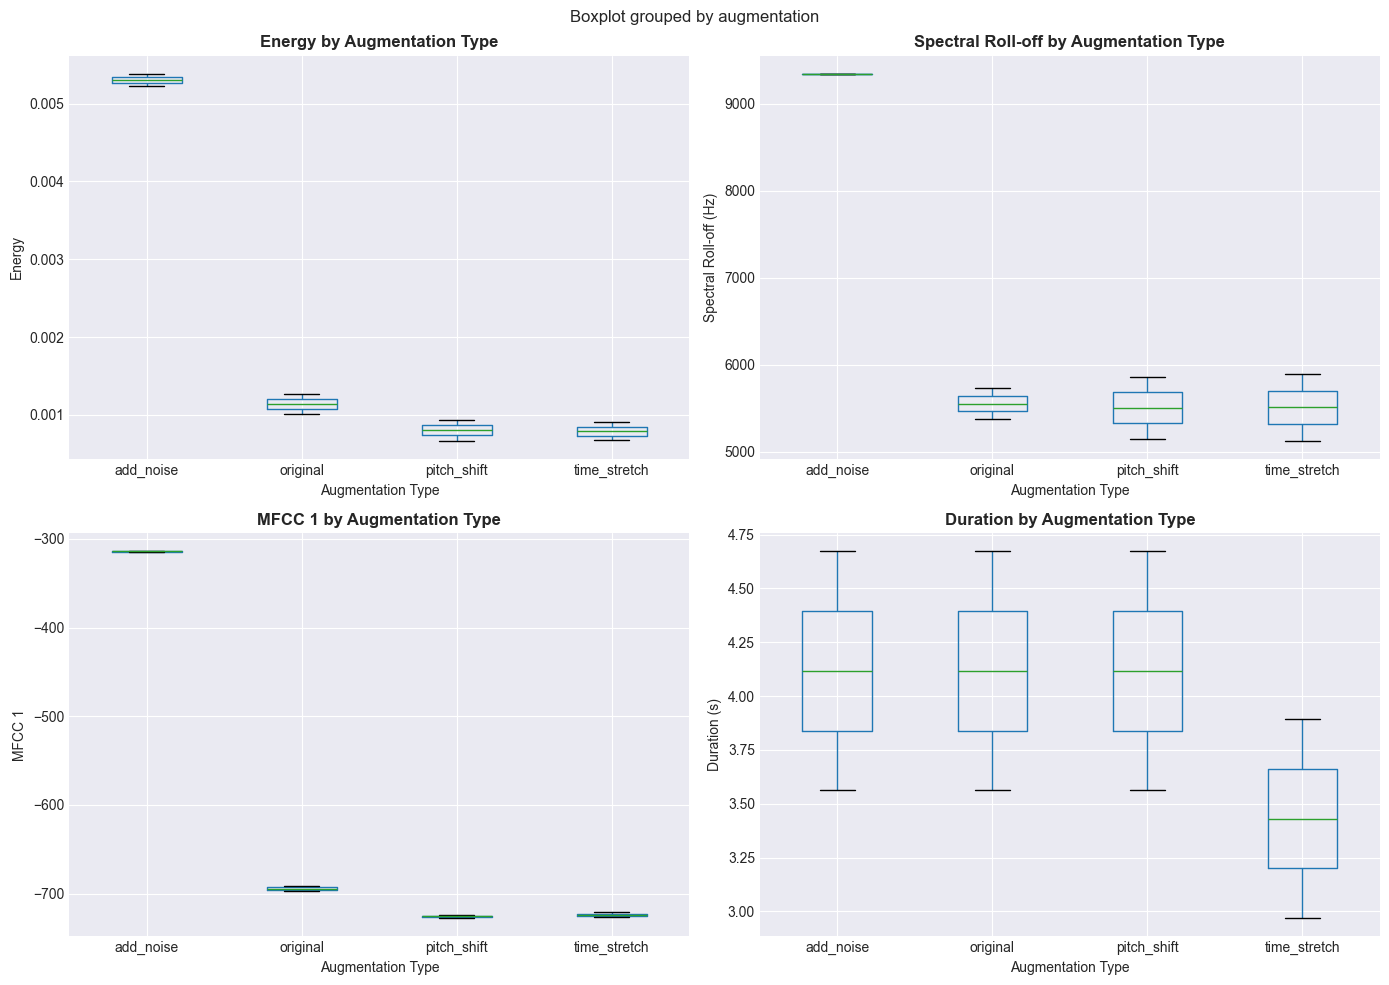

In [16]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Energy distribution
df_features.boxplot(column='energy', by='augmentation', ax=axes[0, 0])
axes[0, 0].set_title('Energy by Augmentation Type', fontweight='bold')
axes[0, 0].set_xlabel('Augmentation Type')
axes[0, 0].set_ylabel('Energy')

# Spectral roll-off distribution
df_features.boxplot(column='spectral_rolloff', by='augmentation', ax=axes[0, 1])
axes[0, 1].set_title('Spectral Roll-off by Augmentation Type', fontweight='bold')
axes[0, 1].set_xlabel('Augmentation Type')
axes[0, 1].set_ylabel('Spectral Roll-off (Hz)')

# MFCC 1 distribution
df_features.boxplot(column='mfcc_1', by='augmentation', ax=axes[1, 0])
axes[1, 0].set_title('MFCC 1 by Augmentation Type', fontweight='bold')
axes[1, 0].set_xlabel('Augmentation Type')
axes[1, 0].set_ylabel('MFCC 1')

# Duration distribution
df_features.boxplot(column='duration', by='augmentation', ax=axes[1, 1])
axes[1, 1].set_title('Duration by Augmentation Type', fontweight='bold')
axes[1, 1].set_xlabel('Augmentation Type')
axes[1, 1].set_ylabel('Duration (s)')

plt.tight_layout()
plt.show()


## Summary

✓ Loaded and displayed waveforms and spectrograms for all audio samples

✓ Applied 3 augmentations per sample (pitch shift, time stretch, add noise)

✓ Extracted features: MFCCs (13 coefficients), spectral roll-off, and energy

✓ Saved all features to `audio_features.csv`

The audio_features.csv file contains all extracted features and is ready for use in the multimodal authentication system.
